# Market Segmentation with the Office of Advancement
Zoe Blumenfeld, Yoo Jin Jeong, Andrew Shen and Siddharth Engineer

## Introduction
Working with the Office of Advancements, we would like to use Data Analysis to increase the donation revenue that The Ohio State University receives. We will not distinguish between types of donations (scholarship funds, Peletonia, general donation, etc). While different types may have a varying level of impact in the eyes of the Office of Advancements, a donation to any cause represents the overal givingness of any individual.

We would like to find a meaningful grouping of donors which reveals ways to which will increase the total amount of donations that the Office of Advancements receives. Therefore, we will be performing market segmentation via a clustering analysis of all our donors. Ideally, our clusterings reveal information on how to market to individuals while also representing their underlying personalities. Finally, we wish to provide actionable results based on these clusters/groupings.

### Loading Data / Packages

The data set we are exploring is the full data set from the Office of Advancement containing 2.3 million rows and 157 columns.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

In [8]:
adv = pd.read_csv('input/adv.csv')

/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_83013/1401441191.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  adv = pd.read_csv('input/adv.csv')


### Cleaning

Our first step in cleaning the data will be removing columns that we will not be using in our modeling. 

We removed the columns containing the name and address of individuals because this was too specific for our modeling. The individuals will still have distinct identifiers in the 'UniqueID' column. We will also be dropping location data (city, zip code, address) and simply using HomeState to avoid overfitting. Additionally, important location information about education and income level within different areas is represented by other predictors (ie. val_pop_ispsa_index).

Finally, we removed columns containing our data maps because these were duplicated information from other columns in the dataframe (and didn't provide any row-wise information).

In [9]:
drop_cols = ['FirstName', 'MiddleName', 'LastName', 
'HomeAddressStreet1', 'HomeAddressStreet2', 'HomeAddressSystemID',  'HomeCity',
'cat_demo_gender_map', 'cat_demo_marital_status_map',
'cat_demo_person_type_map', 'cat_demo_dwelling_size_map',
'cat_financial_mortgage_remainder_amount_map',
'cat_financial_estimated_income_range_map',
'cat_demo_occupation_map', 'cat_demo_education_map',
'cat_calc_political_persona_map', 'cat_calc_social_score_map',
'cat_demo_dual_income_map', 'cat_ta_total_identified_assets_map',
'cat_ta_wealth_segments_map', 'cat_score_donor_persona_map',
'cat_score_p2p_persona_map',
'val_score_philanthropic_score_map','val_score_direct_marketing_score_map',
'val_score_telemarketing_score_map','val_score_online_score_map',
'val_score_sustainer_score_map','val_score_giving_tuesday_score_map',
'val_score_end_of_year_score_map','val_score_p2p_event_score_map',
'val_score_p2p_diy_score_map','cat_demo_date_of_birth',
'SubmitDate', 'Source', 'Not_in_use', '_rescued_data',
'TAS_ID','n_tran_credit_card_purchase','SubmitDate', 'Source', 'Not_in_use', '_rescued_data',
'TAS_ID','n_tran_credit_card_purchase','Unnamed: 0']

In [10]:
adv.drop(drop_cols, axis=1, inplace = True)

Next, we filtered down the data to a more meaningful subset to analyze.

After exploring the data tables provided by Blackbaud we decided to subset the data based on the Target Analytics Wealth Segments. Since our goal was to understand the main donor block that donated smaller amounts more regularly, we decided to filter out the Philanthropists, and the Affluent/Non Affluent Enigmas. Philanthropists were described as stable donors with ample means and were recommended to strategies with them in a more one-on-one partnership for large scale events. The affluent enigmas were similar to Philanthropists in means but had not yet been tapped into as a donor base. The Nonaffluent Enigmas were described as not having the means or interest in donations and had been identified as individuals to whom the Office of Advancement should lessen their investments.

We decided to only focus on the Humanitarian and Casual Donors. Together these groups make up 48% of the US population. These individuals are more likely in the middle class but have an interest in donating. They have been identified as individuals that the Office of Advancement should seek out and solicit for donations. 

In the dataset, values 4 through 10 are the values for the wealth segments in Humanitarians and Casual Donors.

In [11]:
keep_ta_wealth = np.logical_and(adv.cat_ta_wealth_segments <= 10, adv.cat_ta_wealth_segments >= 4)

Our other method of filtering was to remove donors who have an average gift amount above \\$1,000. This will provide us with a more similar grouping of individuals where we can target increasing donor retention or donation amounts. However, donors who give above $1,000 on average will deviate from our general population in income-related categories and/or are already consistent donors. Below, our final subset includes 781438 rows and 118 columns.

In [12]:
keep_avg_donation = np.logical_or(adv.amt_lifetime_giving < 1000, (adv.amt_lifetime_giving / adv.N_DONOR_GIFT) < 1000)
keep = np.logical_and(keep_ta_wealth, keep_avg_donation)
adv_subset = adv[keep]
adv_subset.head(5)

,UniqueID,HomeState,HomePostCode,cat_demo_gender,val_demo_age,cat_demo_marital_status,cat_demo_person_type,ind_demo_home_owner,cat_demo_dwelling_size,n_demo_length_of_residence,...,val_score_online_score,val_score_sustainer_score,val_score_giving_tuesday_score,val_score_end_of_year_score,val_score_p2p_event_score,val_score_p2p_diy_score,cat_score_p2p_persona,amt_lifetime_giving,N_DONOR_GIFT,FY_DONOR_GIFT_FIRST
163,12520891,MA,01001-3323,F,77.0,U,P,1.0,A,7.0,...,416.0,342.0,311.0,237.0,140.0,389.0,9.0,20.40,1.0,2017.0
165,13094562,MA,01001-2871,F,67.0,M,P,1.0,A,33.0,...,975.0,920.0,975.0,982.0,987.0,689.0,4.0,25.74,1.0,2019.0
169,12273167,MA,01002-2807,M,49.0,M,P,NaN,NaN,14.0,...,915.0,613.0,877.0,681.0,631.0,704.0,2.0,50.48,3.0,2015.0
176,12544508,MA,01002-2922,M,62.0,M,P,1.0,A,20.0,...,664.0,875.0,821.0,950.0,968.0,798.0,2.0,0.00,0.0,NaN
180,253834,MA,01002-2504,M,NaN,M,P,NaN,NaN,1.0,...,772.0,599.0,560.0,662.0,489.0,701.0,3.0,70.00,2.0,2009.0


### Exploratory Data Analysis

Our next step was to explore the correlation between all the columns in the dataset. To visualize this we can see below a correlation heatmap containing only columns with at least an absolute correlation of 0.9 with another column in the dataframe. If columns are highly correlated with one another, they do not both need to be in our model since they contain similar information. 

Text(0.5, 1.0, 'Heatmap of Highly Correlated Columns Within the Dataframe')

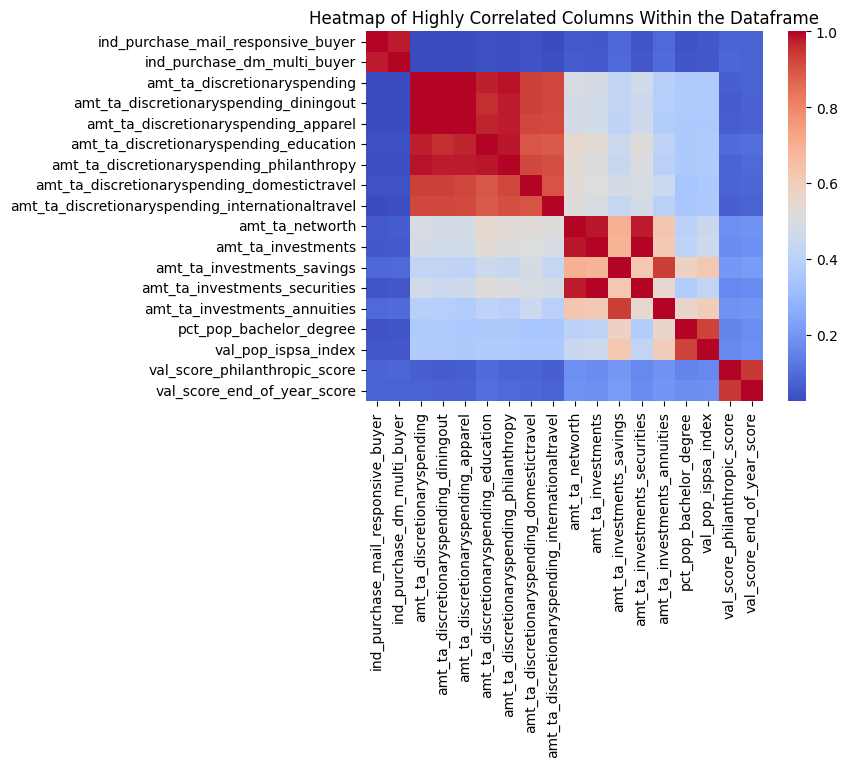

In [13]:
num_data = adv_subset.select_dtypes(include=[np.number])
corr_matrix = num_data.corr()
correlated = corr_matrix[(corr_matrix >= 0.9) & (corr_matrix < 1)].abs().max()
correlated = correlated[~correlated.isna()]
rows_to_include = list(correlated.index)
sns.heatmap(adv[rows_to_include].corr(), annot=False, cmap='coolwarm')
plt.title('Heatmap of Highly Correlated Columns Within the Dataframe')

Our first step will be to remove ind_purchase_mail_responsive_buyer since it has a .98 correlation with ind_purchase_dm_multi_buyer. As well as removing amt_ta_investments due to its extremely high correlation with amt_ta_networth. We will retain information about where people invested but not keep the total investment value since this is captured by net worth.

In [14]:
adv_subset =  adv_subset.drop(columns=['ind_purchase_mail_responsive_buyer'])

To deal with the discretionary spending correlation and the investment spending correlation we decided to transform these columns to be proportions of total spendings/investments to remove correlation. After deriving the proportions of investments we also decided to remove the total investments column, amt_ta_investments, since this was highly correlated with an individual's net worth, amt_ta_networth.

In [15]:
### Turns discretionary spending into proportion
columns_to_change = list(adv_subset.columns[adv_subset.columns.str.contains('discretionaryspending_')])
row_sum = adv_subset[columns_to_change].sum(axis=1)
percent = adv_subset[columns_to_change].div(row_sum, axis=0) * 100
adv_subset[columns_to_change] = percent

### Turns investments into proportion
columns_to_change = list(adv_subset.columns[adv_subset.columns.str.contains('amt_ta_investments_')])
row_sum = adv_subset[columns_to_change].sum(axis=1)
percent = adv_subset[columns_to_change].div(row_sum, axis=0) * 100
adv_subset[columns_to_change] = percent

adv_subset =  adv_subset.drop(columns=['amt_ta_investments'])

To deal with the correlation of the val_pop_ispa_index and the pct_pop_bachelor_degree, we decided to remove all of the columns that were indicating the percent of the population gaining a certain education level and only include the ISPSA index score since this is a classification of the area which takes into account census factors related to education levels and occupation. This also allowed us to remove the occupation categorical variable which we also believed was less helpful to us because it contained over 50 categories and had a high percentage of NA values.

In [16]:
adv_subset = adv_subset.drop(columns = ['pct_pop_high_school_grad',
 'pct_pop_some_college',
 'pct_pop_associate_degree',
 'pct_pop_bachelor_degree',
 'pct_pop_graduate_degree','cat_demo_occupation'])

To manage the high correlation between the philanthropic score and the end of year score we decided to exclude the philanthropy score from our model since this was a more broad score of modeling. We instead wanted to focus on the specific giving scores. We will still keep the philanthropic score in our dataframe as a way to describe our clusters later.

For measuring our results in the later sections, let's define a variable of "Log Giving" which takes the base-10 logarithm of our Lifetime Amount Giving value for each person. Note that we are going to add one to each value to avoid assigning a value of negative infinity to people who have not donated. We are making this transformation due to the skewness of our data.

In [17]:
adv_subset["Log_Giving"] = np.log10(adv_subset["amt_lifetime_giving"] + 1)

The dataset is now cleaned of variables that would cause issues of collinearity and we can begin to create our models.

## Modeling / Analysis
In this section, we are going to model our data using two different methods. Each method is going to capture a different aspect of how we perform market segmentation. For the first method, we want to understand the personality of donors through their discretionary spending. We will perform K-Means clustering on the proportion of discretionary spending in each category for all individuals. The categories for discretionary spending are dining out, apparel, education, philanthropy, domestic travel, international travel, and entertainment. This should reveal underlying groupings of donor preferences when it comes to spending and avenues of interest when it comes to contributing money.

The second method of modeling is to understand the best way we can market to all of our donors. We will perform a K-Means clustering on the Marketing Scores for different categories. The categories for marketing are direct marketing, telemarketing, online, Giving Tuesday, End of Year, P2P event, P2P DIY, and an overall sustainer score. This should reveal the ideal ways in which we can market to different individuals.

### Discretionary Spending Subset

The first thing we want to model is how people spend their money. By identifying groups of spenders, we can characterize them on this basis. Therefore, we'll use the percentage of discretionary spending on each category as our seven predictors.

##### Subsetting

In [18]:
cols = [i for i in adv_subset.columns if 'amt_ta_discretionaryspending' in i]
disc_keep = np.logical_not(adv_subset[cols].isna().any(axis=1))
renamed = {cols[i]: cols[i][29:] for i in range(1, len(cols))}
disc_subset = adv_subset[cols].dropna().drop('amt_ta_discretionaryspending', axis = 1)
disc_subset.rename(renamed, axis = 1, inplace = True)
print("Total rows:", len(disc_subset))
disc_subset.head()

Total rows: 776233


,diningout,entertainment,apparel,education,philanthropy,domestictravel,internationaltravel
163,25.487256,12.743628,19.340330,5.547226,15.142429,14.842579,6.896552
165,29.865772,1.510067,17.617450,7.046980,16.778523,16.946309,10.234899
169,25.662076,8.289195,16.313559,8.183263,16.075212,15.333686,10.143008
176,27.170105,2.672895,16.945634,10.302323,14.623070,14.337615,13.948359
180,26.484018,7.305936,17.199391,6.240487,15.372907,15.220700,12.176560


As seen above, there is a significant difference from individual to individual. Let's look at a correlation matrix below.

##### Modeling

[Text(0.5, 1.0, 'Heatmap of Discretionary Spending Categories')]

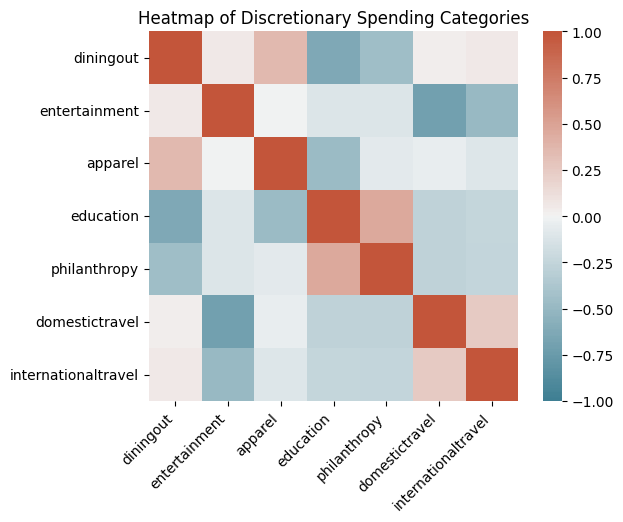

In [19]:
corr = disc_subset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set(title="Heatmap of Discretionary Spending Categories")

As seen above, by taking the proportion of discretionary spending on each category we've removed all correlations that may have existed prior based on the total spending level of individuals (people with more money are going to spend more in all categories). This should be able to adequately reflect each observation's personal interests.

Note that each category may not be distributed in the same ways as other categories. For example, individuals tend to spend more money dining out (with a greater variance) than they do on international travel. Thus, we will perform principal components analysis to ensure well distributed data. Plus, we'll be able to visualize the majority of this distribution.

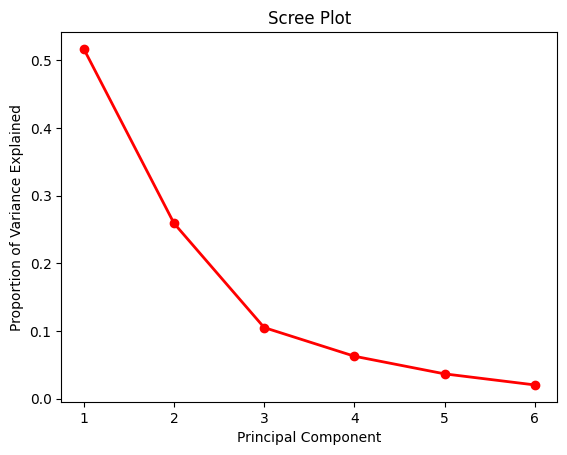

In [20]:
pca = PCA('mle')
X = pca.fit_transform(disc_subset.to_numpy())
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In the scree plot above, it appears that we have 4 principal components. We will use this as it should capture over 90% of the variability in our raw data. Next, we'll visualize the first 3 of these components.

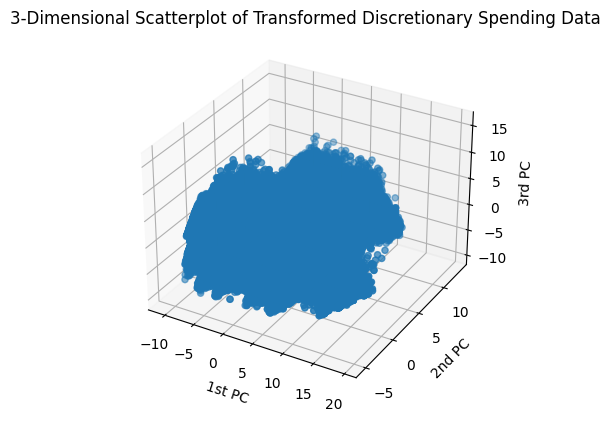

In [32]:
pca = PCA(4)
X = pca.fit_transform(disc_subset)
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
ax.set(title = "3-Dimensional Scatterplot of Transformed Discretionary Spending Data")
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

As you can tell, our data is very well distributed.

Now let's define a function. In order to compare clusterings and find the optimal number of clusters, we need some sort of measure for the total amount of variance within our clusters. Thus we'll define the method below which finds the sum of square distances from each point to its cluster centroid.

In [29]:
def intra_cluster_var(df, labels):
    clusters = np.unique(labels)
    sum = 0
    for i in clusters:
        subset = df[labels == i]
        centroid = subset.mean(axis=0)
        ssq = np.sum((subset - centroid) ** 2, axis = 1).sum()
        sum += ssq
    return sum

Now, we'll use our variance metric to perform an elbow method to find the ideal number of clusters. Based on our data being continuous and well distributed (after performing PCA), we will try out K-Means clustering.

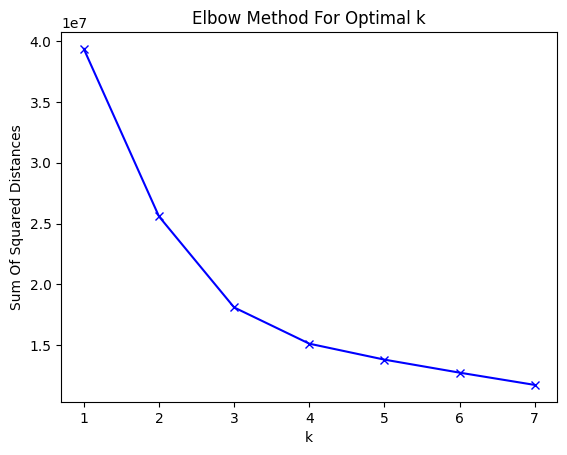

In [30]:
k_ssd = []
k_clusterings = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters = k, random_state = 0, init = "k-means++", n_init = 10).fit(X)
    var = intra_cluster_var(disc_subset, km.labels_)
    k_ssd.append(var)
    k_clusterings.append(km)

plt.plot(K, k_ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum Of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the elbow plot above, we could use either 3 or 4 clusters to capture a majority of the variance in our data. Since our goal is to perform market segmentation and derive meaningful insights from our clusterings, we'll tend towards using a lower number of clusters. Now with 3 clusters, let's visualize this on the first three dimensions of our data.

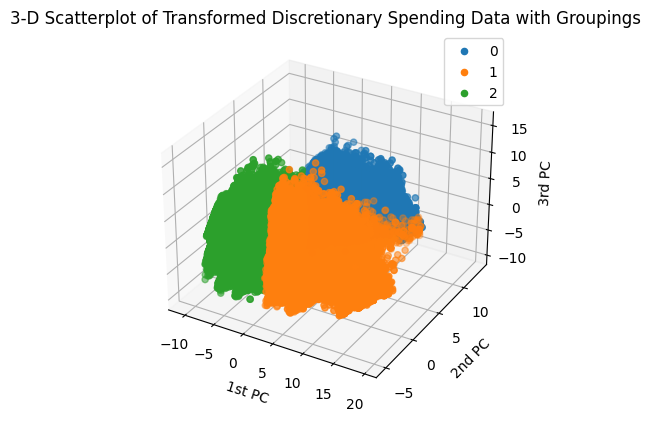

In [33]:
n_clusters = 3
kmeans = k_clusterings[n_clusters - 1]
disc_labels = kmeans.labels_
u_labels = np.unique(disc_labels)

ax = plt.figure().add_subplot(projection='3d')
ax.set(title = "3-D Scatterplot of Transformed Discretionary Spending Data with Groupings")
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
for i in u_labels:
    ax.scatter(X[disc_labels == i , 0] , X[disc_labels == i , 1], X[disc_labels == i, 2], label = i)
plt.legend()
plt.show()

As seen above, our K-Means algorithm created some very distinct and even splits. In the next section, we'll see how these clusters perform in categorizing individuals.

##### Results

Let's expand our subset of data to include variables other than discretionary spending. We will also add the labels generated by our K-Means algorithm above.

In [34]:
disc_frame = adv_subset[disc_keep]
disc_frame["Labels"] = disc_labels

/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_83013/949531040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disc_frame["Labels"] = disc_labels


Now we'll visualize a box plot of "Log Giving" for each of our clusters. As seen below, at least 25% of each cluster are non-donors (1st quartile in each is at 0 for Log Giving). However, our first cluster has a slightly larger amount given than the other two clusters. Although small, it captures that spending habits can have an influence on donation totals, even when controlling for total spending.

[Text(0.5, 1.0, 'Boxplot of Log Giving Between Spending Clusters')]

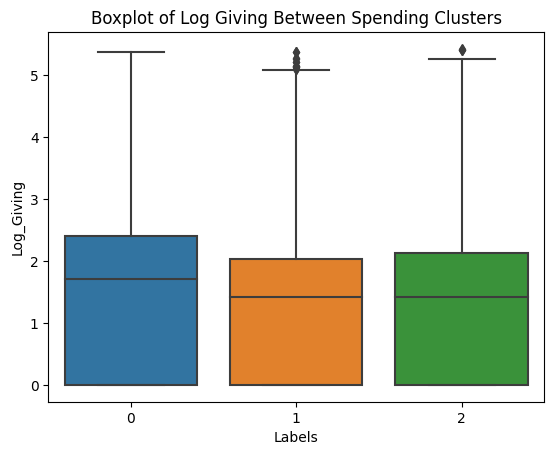

In [37]:
ax = sns.boxplot(x = "Labels", y = "Log_Giving", data = disc_frame)
ax.set(title = "Boxplot of Log Giving Between Spending Clusters")

Next, let's observe some side by side box plots for each of our spending values. This can help to interpret the basis for which our K-Means algorithm split up our clusters. As seen below, the first cluster spends the least on dining out and apparel but spends more on education and philanthropy. The second and third clusters are quite similar, but our second cluster stands out in regard to spending on entertainment whereas our third cluster tends to spend more on travel.

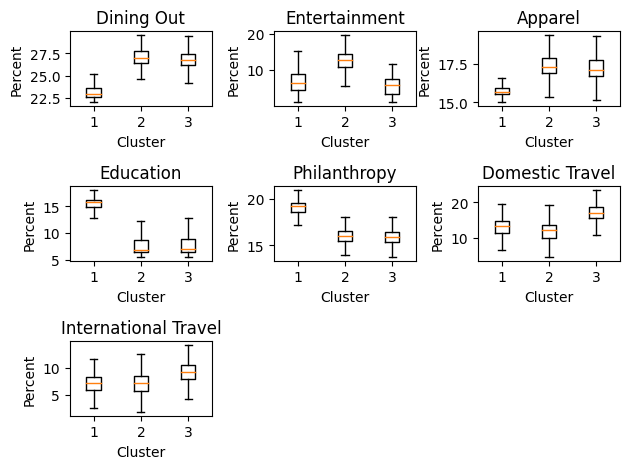

In [42]:
plot_pos = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0)]
plots = []
cols = disc_subset.columns
col_names = ["Dining Out", "Entertainment", "Apparel", "Education", "Philanthropy", "Domestic Travel", "International Travel"]

for i in range(7):
    plots.append(plt.subplot2grid((3, 3), plot_pos[i]))
    data = [disc_subset[cols[i]][disc_labels == j] for j in range(n_clusters)]
    plots[i].boxplot(data, sym = '')
    plots[i].set_title(col_names[i])
    plots[i].set_ylabel("Percent")
    plots[i].set_xlabel("Cluster")

plt.tight_layout()
plt.show()

Next, we'll visualize our spending percentages side by side one another.

In [43]:
colnames = ['Cluster','Type', 'Value']
disc_df = pd.DataFrame(columns = colnames)
for cluster in range(0,3):
    curr_cluster = disc_frame[disc_frame["Labels"] == cluster]
    disc_df.loc[len(disc_df.index)] = [cluster,'Dining out', curr_cluster["amt_ta_discretionaryspending_diningout"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'Apparel', curr_cluster["amt_ta_discretionaryspending_apparel"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'Entertainment', curr_cluster["amt_ta_discretionaryspending_entertainment"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'Education', curr_cluster["amt_ta_discretionaryspending_education"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'Philanthropy', curr_cluster["amt_ta_discretionaryspending_philanthropy"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'Domestic travel', curr_cluster["amt_ta_discretionaryspending_domestictravel"].mean()]
    disc_df.loc[len(disc_df.index)] = [cluster,'International travel', curr_cluster["amt_ta_discretionaryspending_internationaltravel"].mean()]

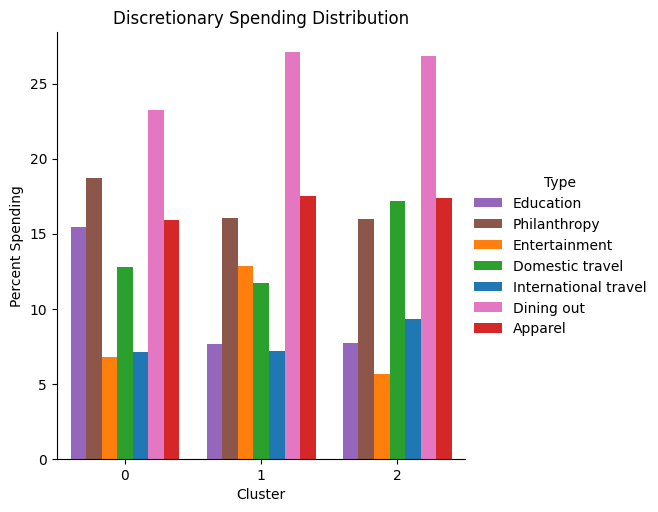

In [44]:
palette = {
    'Dining out': 'tab:pink',
    'Apparel': 'tab:red',
    'Entertainment': 'tab:orange',
    'Education': 'tab:purple',
    'Philanthropy': 'tab:brown',
    'Domestic travel': 'tab:green',
    'International travel': 'tab:blue'
}
order = ["Education", "Philanthropy", 'Entertainment', "Domestic travel" , "International travel", "Dining out", "Apparel"]
ax = sns.catplot(hue = "Type", 
            palette=palette,       # x variable name
            y = "Value",       # y variable name
            x = "Cluster",  # group variable name
            data = disc_df,     # dataframe to plot
            kind = "bar",
            height = 5,
            saturation=1,
            hue_order = order)
ax.set(xlabel='Cluster', ylabel='Percent Spending', title = "Discretionary Spending Distribution")

As seen above, out of all categories individuals tend to spend the most on dining out. Additionally, we can see that entertainment, international travel, and education is more typically a smaller expense. However, these values vary from cluster to cluster.

### Marketing Score Clustering

The next thing we wanted to model was the marketing scores of individuals. Identifying which type of marketing resonates best with each individual enables personalized marketing methods for different groups of individuals.

##### Subsetting

From our original "adv" dataframe, we are going to only use the Marketing Score categories. We will remove all other columns and drop the rows which have remaining NA values. In the last step, we will normalize the columns to prepare for clustering.

In [48]:
score_cols = ['val_score_direct_marketing_score', 'val_score_telemarketing_score', 'val_score_online_score',
                    'val_score_giving_tuesday_score', 'val_score_end_of_year_score', 'val_score_p2p_event_score',
                    'val_score_p2p_diy_score', 'val_score_sustainer_score']
score_keep = np.logical_not(adv_subset[score_cols].isna().any(axis=1))
renamed = {score_cols[i]: score_cols[i][10:-6] for i in range(len(score_cols))}
score_subset = adv_subset[score_cols].dropna()
score_subset.rename(renamed, axis = 1, inplace = True)
print("Length of Updated Dataframe:", len(score_subset))

# Normalize the dataframe
score_subset=(score_subset-score_subset.min())/(score_subset.max()-score_subset.min())
score_subset = score_subset.dropna()
score_subset.head()

Length of Updated Dataframe: 781347


,direct_marketing,telemarketing,online,giving_tuesday,end_of_year,p2p_event,p2p_diy,sustainer
163,0.618,0.272,0.416,0.311,0.237,0.140,0.335147,0.342
165,0.491,0.917,0.975,0.975,0.982,0.987,0.661589,0.920
169,0.422,0.526,0.915,0.877,0.681,0.631,0.677911,0.613
176,0.424,0.843,0.664,0.821,0.950,0.968,0.780196,0.875
180,0.681,0.740,0.772,0.560,0.662,0.489,0.674646,0.599


##### Modeling

With our normalized data, we would like to perform a K-Means clustering to divide up our marketable groups. This will allow us to create different marketing strategies for communicating with our donors. Let's perform the elbow method to find the optimal number of clusters.

In [50]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))
score_clusterings = []

for k in list_k:
    km = KMeans(n_clusters = k, random_state = 0, init = "k-means++", n_init = 10).fit(score_subset)
    var = intra_cluster_var(score_subset, km.labels_)
    sse.append(var)
    score_clusterings.append(km)

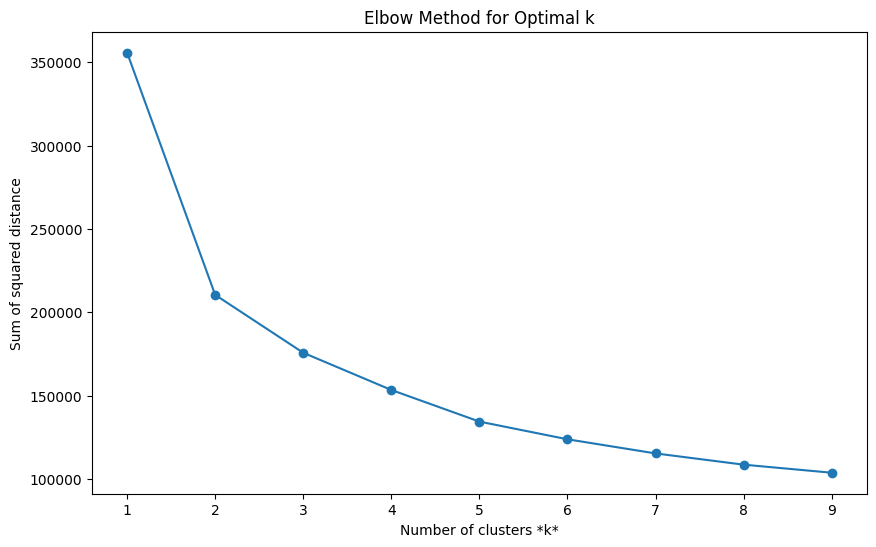

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.title("Elbow Method for Optimal k")
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
_ = plt.xticks(range(1,10))

Based on the elbow method, we decide to stick with 4 clusters for our model.

In [53]:
n_clusters = 4
km = score_clusterings[n_clusters - 1]
score_labels = km.labels_

##### Results

Let's expand our subset of data to include variables other than marketing score. We will also add the labels generated by our K-Means algorithm above.

In [ ]:
score_frame = adv_subset[score_keep]
score_frame["score_labels"] = score_labels
counter = 0

Now, let's observe some side by side box plots for each of our score values. As seen below, four clusters show different distributions for each type of score.

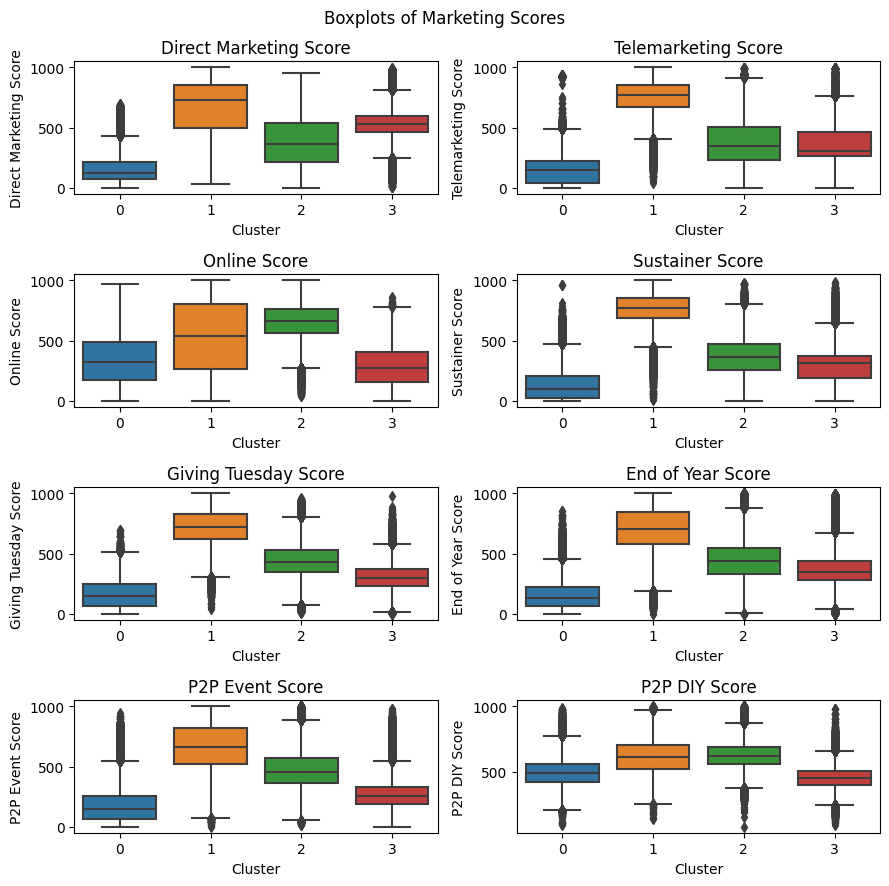

In [55]:
scores = ["val_score_direct_marketing_score", "val_score_telemarketing_score", "val_score_online_score", "val_score_sustainer_score",
          "val_score_giving_tuesday_score", "val_score_end_of_year_score", "val_score_p2p_event_score", "val_score_p2p_diy_score"]
titles = ["Direct Marketing Score", "Telemarketing Score", "Online Score", "Sustainer Score",
          "Giving Tuesday Score", "End of Year Score", "P2P Event Score", "P2P DIY Score"]

plot_pos = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
fig, axes = plt.subplots(4, 2, figsize = (9,9))
fig.suptitle('Boxplots of Marketing Scores')

for i in range(8):
    sns.boxplot(ax = axes[plot_pos[i][0], plot_pos[i][1]], x = 'score_labels', y = scores[i], data = score_frame)
    axes[plot_pos[i][0], plot_pos[i][1]].set(xlabel='Cluster', ylabel=titles[i], title = titles[i])

plt.tight_layout()
plt.show()

As seen in the boxplots above, cluster 0 is extremely unlikely to donate through any category. However, they are most likely to donate online or DIY. Cluster 1 is most likely to donate overall, especially in telemarketing. Cluster 2 is our second most likely category to donate, and they like to donate online and DIY the most by far. Finally, cluster 3 prefers direct marketing tactics. Below, we will use bar charts to easily compare strategies within clusters.

In [56]:
colnames = ['Cluster', 'Type', 'Value']
score_df = pd.DataFrame(columns = colnames)
for cluster in range(0,4):
    curr_cluster = score_frame[score_frame["score_labels"] == cluster]
    score_df.loc[len(score_df.index)] = [cluster, 'Direct Marketing', curr_cluster["val_score_direct_marketing_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'Telemarketing', curr_cluster["val_score_telemarketing_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'Giving Tuesday', curr_cluster["val_score_giving_tuesday_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'End of Year', curr_cluster["val_score_end_of_year_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'Sustainer', curr_cluster["val_score_sustainer_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'P2P Event', curr_cluster["val_score_p2p_event_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'P2P Diy', curr_cluster["val_score_p2p_diy_score"].mean()]
    score_df.loc[len(score_df.index)] = [cluster, 'Online', curr_cluster["val_score_online_score"].mean()]

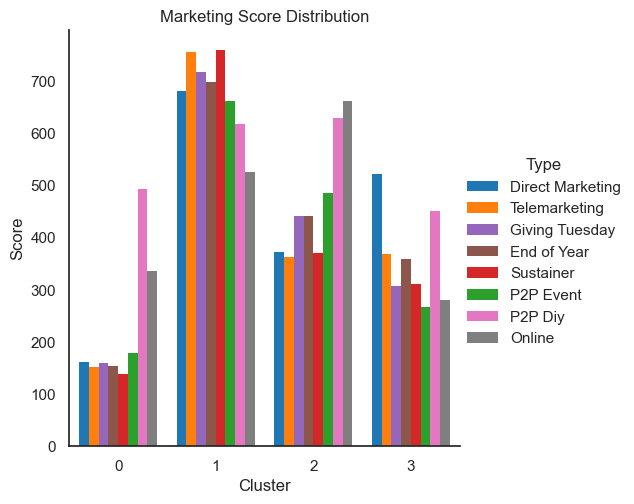

In [57]:
sns.set_theme(style='white')
sns.set_context(rc = {'patch.linewidth': 0.0})

palette = {
    'Direct Marketing': 'tab:blue',
    'Telemarketing': 'tab:orange',
    'Giving Tuesday': 'tab:purple',
    'End of Year': 'tab:brown',
    'Sustainer': 'tab:red',
    'P2P Event': 'tab:green',
    'P2P Diy': 'tab:pink',
    'Online': 'tab:grey'
}

ax = sns.catplot(hue = "Type",
            palette=palette,       # x variable name
            y = "Value",       # y variable name
            x = "Cluster",  # group variable name
            data = score_df,     # dataframe to plot
            kind = "bar",
            height = 5,
            saturation=1)
ax.set(xlabel='Cluster', ylabel='Score', title = "Marketing Score Distribution")

From the barplot above, we can reaffirm that cluster 0 has overall low scores for most of the marketing types. On the other hand, cluster 1 shows high scores overall. From this marketing score distribution by each cluster, we can see that scores vary from cluster to cluster. This allows us to specifically use certain techniques when contacting different groups.

### Combining Clusters

The final step of our modeling process is combining all of the work above. By combining the discretionary spending clusters with the marketing score clusters, we're able to identify intersections within the clusters to create grouped personas that allow for personalized market strategies that align both with how they spend money and which marketing methods they respond best to.

First, we will come up with names for each of our clusters (3 different spending clusters and 4 different marketing clusters). We will replace the cluster indexes with their names.

In [58]:
spending_cluster = pd.read_csv('output/spending_cluster.csv').rename({"ClusterID": "Spending_Cluster"}, axis=1)
spending_map = {0: "Altruists", 1: "Consumers", 2: "Travelers"}
marketing_cluster = pd.read_csv('output/marketing_cluster.csv').rename({"ClusterID": "Marketing_Cluster"}, axis=1)
marketing_map = {0: "Independents", 1: "Socialites", 2: "Virtuals", 3: "Prompted Patrons"}

spending_cluster.Spending_Cluster = spending_cluster["Spending_Cluster"].map(spending_map)
marketing_cluster.Marketing_Cluster = marketing_cluster["Marketing_Cluster"].map(marketing_map)

Then we will merge the cluster labels together with the full data set.

In [59]:
merged = adv_subset.merge(spending_cluster, how='left').merge(marketing_cluster, how='left')

The mosaic below shows the sizes of each of the intersections/personas between the marketing clusters and the spending clusters. On the x-axis we split up the marketing clusters and on the y-axis we split up the spending clusters. As you can see, our travelers are the largest category for grouping people by spending and prompted patrons are the largest category for marketing.

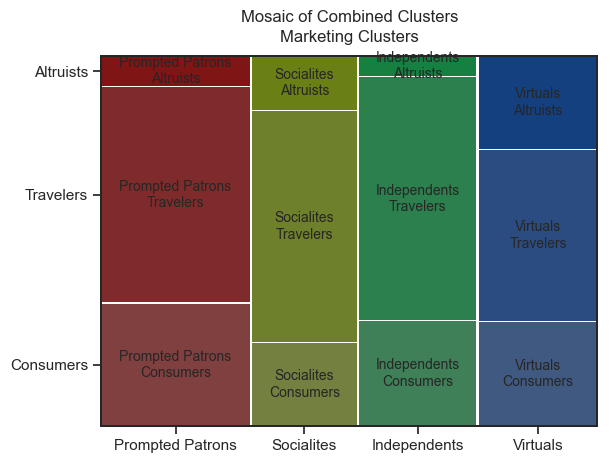

In [61]:
mosaic(merged, ['Marketing_Cluster', 'Spending_Cluster'], title='Mosaic of Combined Clusters')
plt.show()

### Potential Donations Score

To help the Office of Advancements determine which group persona to focus their time and money on, our group created a "Potential Donations Score" metric to measure the value of each persona:

$Number\:of\:People * Average\:Gift\:Amount * Sustainer\:Score = Score\:of\:Potential\:Donations$

In [79]:
merged["amt_average_gift"] = merged["amt_lifetime_giving"] / merged["N_DONOR_GIFT"]
unique_combinations = pd.DataFrame(merged.groupby(['Spending_Cluster', 'Marketing_Cluster']).size().reset_index(name="Intersection"))
grouped_df = merged.groupby(['Spending_Cluster', 'Marketing_Cluster']).agg({"UniqueID": "count", 
                                                          "amt_average_gift": "mean", "val_score_sustainer_score" : "mean"})
result = pd.merge(unique_combinations, grouped_df, on=['Spending_Cluster', 'Marketing_Cluster'])
result = result.rename(columns={'UniqueID':"Number of Individuals",
                                "amt_average_gift": "Average Gift Amount",
                                'val_score_sustainer_score' : "Average Sustainer Score"})
del result['Intersection']
result['Potential Donations'] = result['Number of Individuals']*result['Average Gift Amount']*result['Average Sustainer Score']


Below is the list of Potential Donations for each persona grouping. Note that the differs from the mosaic above showing the size of each cluster. Both will reveal similar information, but this boils it down to the final monetary value but is subject to error if the Potential Donations Score is inaccurate.

In [80]:
result.sort_values('Potential Donations', ascending = False)

,Spending_Cluster,Marketing_Cluster,Number of Individuals,Average Gift Amount,Average Sustainer Score,Potential Donations
10,Travelers,Socialites,104478,79.494834,767.747746,6.376499e+09
9,Travelers,Prompted Patrons,137813,65.587347,317.701712,2.871639e+09
11,Travelers,Virtuals,87792,72.375070,376.417179,2.391737e+09
6,Consumers,Socialites,37602,79.551569,761.678581,2.278408e+09
2,Altruists,Socialites,24401,112.860987,718.989386,1.980040e+09
3,Altruists,Virtuals,47539,102.075396,380.436168,1.846090e+09
5,Consumers,Prompted Patrons,78273,67.223952,295.782313,1.556353e+09
7,Consumers,Virtuals,53317,71.511043,351.342030,1.339581e+09
8,Travelers,Independents,122549,57.998217,138.546051,9.847332e+08
1,Altruists,Prompted Patrons,19166,88.999229,316.420275,5.397368e+08


Looking at the table above, we can see that the Traveler spending personas have the highest potential donations score. There is no clear pattern with the marketing personas. For a better way at visualizing the value of each category, view the heatmap below. Darker shades represent more valuable groups for the Office of Advancement.

/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_83013/1068560997.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  map = value.pivot("Spending_Cluster", "Marketing_Cluster", "Potential Donations")


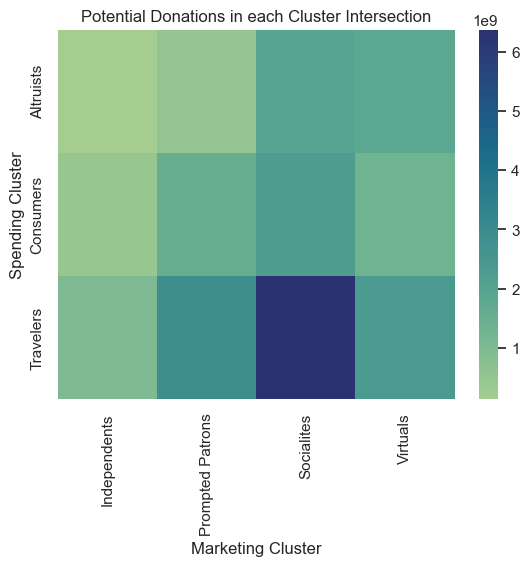

In [81]:
sns.set()
value = result.sort_values('Potential Donations', ascending = False)
map = value.pivot("Spending_Cluster", "Marketing_Cluster", "Potential Donations")
ax = sns.heatmap(map, cmap="crest")
ax.set(xlabel="Marketing Cluster", ylabel="Spending Cluster")
plt.title("Potential Donations in each Cluster Intersection")
plt.show()

## Conclusion

#### Recommendations

After clustering discretionary spending categories and marketing methods separately and intersecting them together, our analysis is left with twelve distinct personas that can be used to describe the population of our data set. Using the potential donations score to evaluate the personas, we can advise the Office of Advancement to focus their efforts on the traveler personas, especially with the Traveling Socialites. 

For future work, more research can be performed to better tailor marketing strategies to the highly valued personas. Next, the formula for calculating the potential donations score should be finetuned to accurately predict the scores. Finally, the clustering that was performed by our group can be expanded to model other wealth segments created by Target Analytics.

#### Dead ends

During our research and modeling, our group stumbled upon many paths that did not seem to lead anywhere. With better data collection and fewer NA values, the following columns and techniques could be researched and implemented:
- Indicator of interest for causes (too many NAs were present)

- Indicator of contribution for causes (too many NAs were present)

- Percent population descriptors (all were correlated with one another)

- Occupation (no intuitive way to bin the occupations together. The inclusion of the raw occupation column would contribute to the problem of dimensionality with its 54 categories)

- Clustering on wealth descriptors (wealth is an obvious indicator of an individual's ability to donate and when clustered on, created clear discrepancies between the rich and the poor. Our group left these columns out of our clustering to derive other meaningful differentiating characteristics within the population)

- Investment distributions (not descriptive of donor personas, each category highly correlated with one another, and proportions only revealed wealth information)

We would like to conclude by saying thank you to the Office of Advancement for the great opportunity to explore a real-world clustering problem with a diverse set of challenges and expectations. 